We can load the hugging face gpt-2 model:

In [1]:
from transformers import GPT2LMHeadModel

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-13 03:36:01.731183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755056161.740447  283571 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755056161.744864  283571 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755056161.750603  283571 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00

Let's take a look at the parameters

In [2]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")

sd_hf = model_hf.state_dict()

for key, value in sd_hf.items():
    print(key, value.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

Generate some text:

In [4]:
from transformers import pipeline, set_seed
generator = pipeline("text-generation", model="gpt2")

set_seed(42)
generator("Hello, I'm a language model,", max_new_tokens=30, num_return_sequences=5)

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, so you can't just use the same data model and just use different languages. There's a lot of overlap between languages because there are so many different"},
 {'generated_text': "Hello, I'm a language model, you know.\n\nThat's right…\n\nIf you read about it, you'll understand how I've written this.\n\nIn this"},
 {'generated_text': "Hello, I'm a language model, not a formal model. I'm more interested in languages than formal models, and as far as I've seen, formal models are the best way to"},
 {'generated_text': "Hello, I'm a language model, which means that if you're a language model, you can write code that writes code that reads the code you want to write. It's easier to"},
 {'generated_text': 'Hello, I\'m a language model, and I\'m not a writer. I just want to be a writer."\n\nI\'m a language model, and I\'m not a writer.'}]

Tiny Shakespeare

In [5]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

with open("input.txt", "r") as f:
    text = f.read()

data = text[:1000]
print(data[:100])

--2025-08-13 03:37:07--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 

connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1           0%[                    ]       0  --.-KB/s               

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.1s    

2025-08-13 03:37:07 (11.0 MB/s) - ‘input.txt.1’ saved [1115394/1115394]

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [6]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


But this is an 1D tensor, we want a (B, T) tensor to feed into the model as idx

In [7]:
import torch
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4, 6) # input
y = buf[1:].view(4, 6) # labels

print(f"x: {x}")
print(f"y: {y}")

for b in range(4):
  print(f"Batch: {b+1}")
  for t in range(6):
    print(f"When input is {x[b, :t+1].tolist()}, the label is {y[b, t]}")
  print()

x: tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
y: tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])
Batch: 1
When input is [5962], the label is 22307
When input is [5962, 22307], the label is 25
When input is [5962, 22307, 25], the label is 198
When input is [5962, 22307, 25, 198], the label is 8421
When input is [5962, 22307, 25, 198, 8421], the label is 356
When input is [5962, 22307, 25, 198, 8421, 356], the label is 5120

Batch: 2
When input is [5120], the label is 597
When input is [5120, 597], the label is 2252
When input is [5120, 597, 2252], the label is 11
When input is [5120, 597, 2252, 11], the label is 3285
When input is [5120, 597, 2252, 11, 3285], the la

Min Train Loss: 2.880896
Min Validation Loss: 3.0938
Max Hellaswag eval: 0.2616


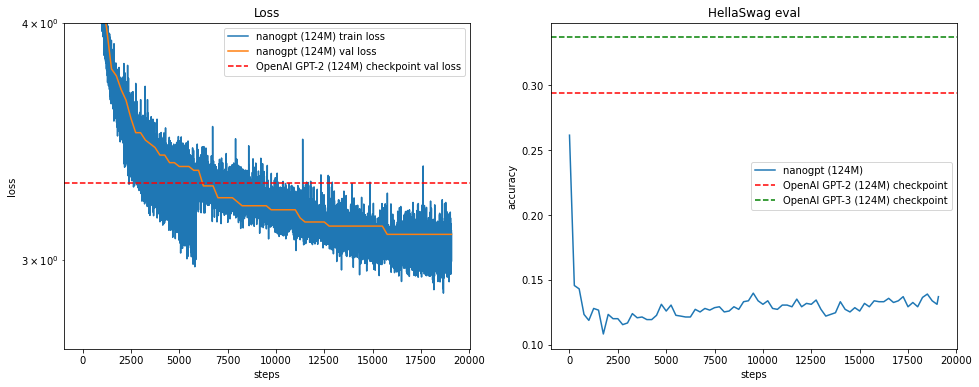

In [1]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["goldenswag"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))